In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [1]:
from tensorflow import keras
from tensorflow.keras import layers

# from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

In [2]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [3]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [4]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [5]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [6]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [7]:
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

In [8]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20)

Epoch 1/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - d_loss: 0.3825 - g_loss: 1.7117
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - d_loss: 0.4970 - g_loss: 1.3098
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - d_loss: 0.4046 - g_loss: 1.5358
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - d_loss: 0.2145 - g_loss: 2.2673
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - d_loss: 0.2314 - g_loss: 2.4971
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - d_loss: 0.5673 - g_loss: 1.2198
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - d_loss: 0.6382 - g_loss: 0.9460
Epoch 8/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - d_loss: 0.6509 - g_loss: 0.8968
Epoch 9/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - d_loss: 0.6592 - g_loss: 0.8332
Epoch 10/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - d_loss: 0.6678 - g_loss: 0.8314
Epoch 11/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - d_loss: 0.6764 - g_loss: 0.8066
Epoch 12

In [9]:
from PIL import Image

# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator


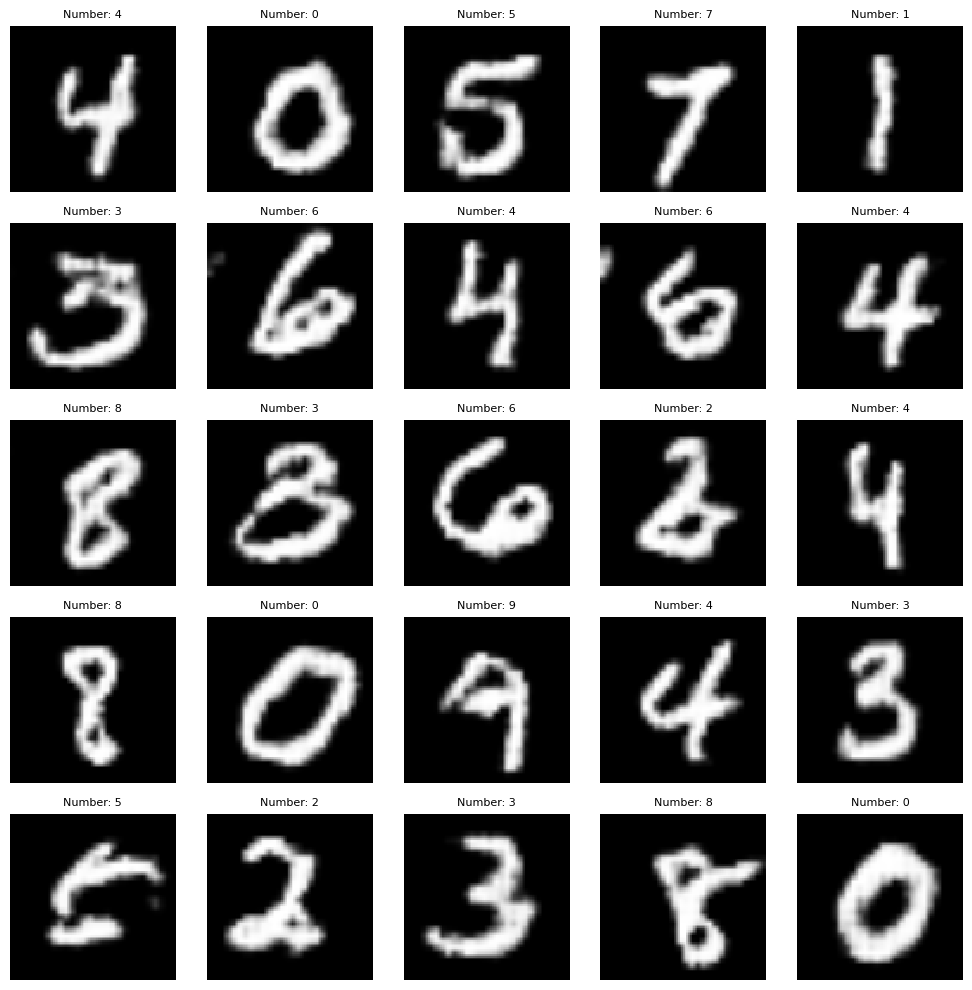

In [12]:
def generate_and_save_images(generator, num_classes, generator_in_channels):
    # Create a 5x5 grid of images
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))

    # Loop over the 5x5 grid
    for i in range(5):
        for j in range(5):
            # Choose a random number
            my_number = np.random.randint(0, num_classes)

            # Sample Noise
            my_noise = tf.random.normal(shape=(1, generator_in_channels - 10))

            # Sample Label
            my_label = keras.utils.to_categorical([my_number], num_classes)
            my_label = tf.cast(my_label, tf.float32)

            # Concatenate noise and label together
            my_input = tf.concat([my_noise, my_label], 1)

            # Make prediction using the trained generator
            fake_num = generator.predict(my_input, verbose=False)

            # Re-scale output
            fake_num *= 255.0

            # Convert to 8-bit int
            converted_image = fake_num.astype(np.uint8)

            # Resize into an actual image shape
            converted_image = tf.image.resize(converted_image, (96, 96)).numpy().astype(np.uint8)

            # Get rid of batch size dimension
            converted_image = np.squeeze(converted_image)

            # Plot on the grid
            ax = axes[i, j]
            ax.imshow(converted_image, interpolation='nearest', cmap='gray')
            ax.axis('off')  # Turn off axes
            ax.set_title(f"Number: {my_number}", fontsize=8)

    plt.tight_layout()
    plt.show()

# Example call to generate 25 random images
generate_and_save_images(trained_gen, num_classes=10, generator_in_channels=generator_in_channels)